In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



DATASET_DIR = Path('data/HYPERVIEW2')

HSI_AIRBORNE_DIR = DATASET_DIR / 'train' / 'hsi_airborne'
HSI_SATELLITE_DIR = DATASET_DIR / 'train' / 'hsi_satellite'
MSI_SATELLITE_TRAIN_DIR = DATASET_DIR / 'train' / 'msi_satellite'
MSI_SATELLITE_TEST_DIR = DATASET_DIR / 'test' / 'msi_satellite'

GT_TRAIN_CSV_PATH = DATASET_DIR / 'train_gt.csv'
# %% Load the ground truth measurements
gt_train_df = pd.read_csv(GT_TRAIN_CSV_PATH)
ydf = gt_train_df.drop(['sample_index'], axis=1)
column_names = ['Fe', 'Zn', 'B', 'Cu', 'S', 'Mn']


class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """

    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


def mse_metric(predictions, y_test, baselines, Yi = None):
    b = pd.Series(baselines, index = column_names)
    yt = pd.DataFrame(y_test, columns=column_names)
    if Yi:
        p = pd.Series(predictions, name = Yi)
        yt = yt[Yi]
        b = b[Yi]
    else:
        p = pd.DataFrame(predictions, columns=column_names)

    err = (yt - p)
    mse = (err**2).mean()
    mse_b = mse / b
    if Yi:
        return pd.Series(mse_b, index = [Yi])
    else:
        mse_b['MEAN_MSE'] = mse_b.mean()
        return mse_b


In [3]:
class AveragingEnsemble(BaseEstimator, RegressorMixin):
    def __init__(self, models, weights=None):
        self.model_names = [i for i,_ in models]
        self.models = [j for _, j in models]
        self.weights = weights

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self

    def predict(self, X):
        preds = np.array([model.predict(X) for model in self.models])
        
        if self.weights is None:
            return preds.mean(axis=0)
        else:
            return np.average(preds, axis=0, weights=self.weights)
        
    def fit_predict(self, X, y):
        self.fit(X, y)
        return self.predict(X)

In [4]:
def load_msi_data(directory):
    files = sorted(directory.glob('*.npz'))
    msi_data = []

    for file in enumerate(files):
        file_name = file[1]
        with np.load(file_name) as npz:
            data, mask = npz['data'], npz['mask']
            arr = np.ma.MaskedArray(data=data, mask=mask)
            mean_pixel = np.mean(arr, axis=(1, 2))  # mean over all pixels
            msi_data.append(mean_pixel)
    msi_data = np.array(msi_data)

    column_names = [
    *['col_%i' % i for i in range(msi_data.shape[0])],
]  
    
    return msi_data, column_names

In [5]:
dir1 = MSI_SATELLITE_TRAIN_DIR
dir2 = MSI_SATELLITE_TEST_DIR
print(f'Loading data from {dir1} and {dir2}')
X_train_all, colnames = load_msi_data(dir1)
X_test_all, colnames = load_msi_data(dir2)

y_train_all = gt_train_df[column_names].values

print(f'X_train shape: {X_train_all.shape}')
print(f'Y_train shape: {y_train_all.shape}')
print(f'X_test shape: {X_test_all.shape}')

Loading data from data/HYPERVIEW2/train/msi_satellite and data/HYPERVIEW2/test/msi_satellite
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
X_test shape: (1888, 12)


In [6]:
rfParams = {'n_jobs': 4,
        'oob_score':True, 
        'max_depth': 10,
        'n_estimators': 200,
        'min_samples_leaf': 4}

gbParams = {
    'n_estimators':95, 'learning_rate':.04, 
}

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ensemble", AveragingEnsemble(models=[
        ('RF' , RandomForestRegressor(**rfParams)),
        ('KNN', KNeighborsRegressor(n_neighbors=7)),
        ('XGB', MultiOutputRegressor(GradientBoostingRegressor(**gbParams))),
        # MultiOutputRegressor(svm.SVR(kernel='rbf', C=2, gamma=180)),
    ]))
])

In [7]:
kf = KFold(n_splits=4)

kf_results = []
for train_idx, test_idx in kf.split(X_train_all):
    
    X_train = X_train_all[train_idx]
    y_train = y_train_all[train_idx]

    X_test = X_train_all[test_idx]
    y_test = y_train_all[test_idx]

# Fit the baseline model
    baseline_reg = BaselineRegressor()
    baseline_reg = baseline_reg.fit(X_train, y_train)
    baseline_predictions = baseline_reg.predict(X_test)

    # Generate baseline values to be used in score computation
    baselines = np.mean((y_test - baseline_predictions) ** 2, axis=0)
    print(f"baseline score: {np.mean(baselines)}")

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    res = mse_metric(preds, y_test, baselines)
    kf_results.append(res)

baseline score: 700.5242031132743


/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


baseline score: 653.0713505881316


/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


baseline score: 688.228858258559


/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


baseline score: 733.9000169676847


/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [8]:
res = pd.DataFrame(kf_results).sort_values('MEAN_MSE')
res.style.background_gradient()

,Fe,Zn,B,Cu,S,Mn,MEAN_MSE
2,0.547222,0.521526,0.407132,0.688272,0.584543,0.488051,0.539458
3,0.477910,0.549371,0.434095,0.688201,0.607367,0.560281,0.552871
1,0.528708,0.585368,0.469491,0.657349,0.566839,0.516648,0.554067
0,0.542388,0.588557,0.404506,0.672967,0.572477,0.564888,0.557630


In [9]:
res.corr().style.background_gradient()

,Fe,Zn,B,Cu,S,Mn,MEAN_MSE
Fe,1.000000,0.079321,-0.348008,-0.299319,-0.793088,-0.512124,-0.287399
Zn,0.079321,1.000000,0.385952,-0.824946,-0.598616,0.551824,0.908437
B,-0.348008,0.385952,1.000000,-0.661575,-0.187997,-0.096528,0.309799
Cu,-0.299319,-0.824946,-0.661575,1.000000,0.816753,-0.005528,-0.556073
S,-0.793088,-0.598616,-0.187997,0.816753,1.000000,0.264568,-0.213464
Mn,-0.512124,0.551824,-0.096528,-0.005528,0.264568,1.000000,0.833507
MEAN_MSE,-0.287399,0.908437,0.309799,-0.556073,-0.213464,0.833507,1.000000


In [10]:
THR = 1500
X_train = X_train_all[:THR]
y_train = y_train_all[:THR]

X_test = X_train_all[THR:]
y_test = y_train_all[THR:]

baseline_reg = BaselineRegressor()
baseline_reg = baseline_reg.fit(X_train, y_train)
baseline_predictions = baseline_reg.predict(X_test)

train_preds = pipeline.fit_predict(X_train, y_train)
preds = pipeline.predict(X_test)
mse_metric(preds, y_test, baselines)

/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Fe          0.474015
Zn          0.463329
B           0.403715
Cu          0.657056
S           0.530470
Mn          0.568214
MEAN_MSE    0.516133
dtype: float64

In [11]:
mse_metric(train_preds, y_train, baselines)

Fe          0.296697
Zn          0.393211
B           0.324290
Cu          0.531961
S           0.381003
Mn          0.393028
MEAN_MSE    0.386699
dtype: float64

# XAI

In [12]:
import shap

indices = np.random.choice(X_test.shape[0], 300, replace=False)
indices_eval = np.random.choice(X_test.shape[0], 100, replace=False)
X_background = X_test[indices]
X_eval = X_train[indices_eval]
X_eval = pd.DataFrame(X_eval).add_prefix('band_')

/home/katarzyna/cv_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
models = pipeline.named_steps["ensemble"].models
model_names = pipeline.named_steps["ensemble"].model_names

In [16]:
shap_per_model = {}

for idx, model in enumerate(models):
    explainer = shap.Explainer(
        model.predict,
        X_background,

    )
    
    shap_values = explainer(X_eval)
    shap_per_model[idx] = shap_values


PermutationExplainer explainer: 101it [01:52,  1.16s/it]                         
PermutationExplainer explainer: 101it [01:22,  1.05it/s]                         
PermutationExplainer explainer: 101it [00:20,  2.69it/s]                         


In [17]:
shap_model_element = {}

for model_idx, shap_values in shap_per_model.items():
    values = shap_values.values
    
    if values.ndim != 3:
        raise ValueError(
            f"Model {model_idx}: unexpected SHAP shape {values.shape}"
        )
    
    n_elements = values.shape[-1]
    
    shap_model_element[model_idx] = {
        elem: values[:, :, elem]
        for elem in range(n_elements)
    }


/tmp/ipykernel_104850/1545342006.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/tmp/ipykernel_104850/1545342006.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/tmp/ipykernel_104850/1545342006.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/tmp/ipykernel_104850/1545342006.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this func

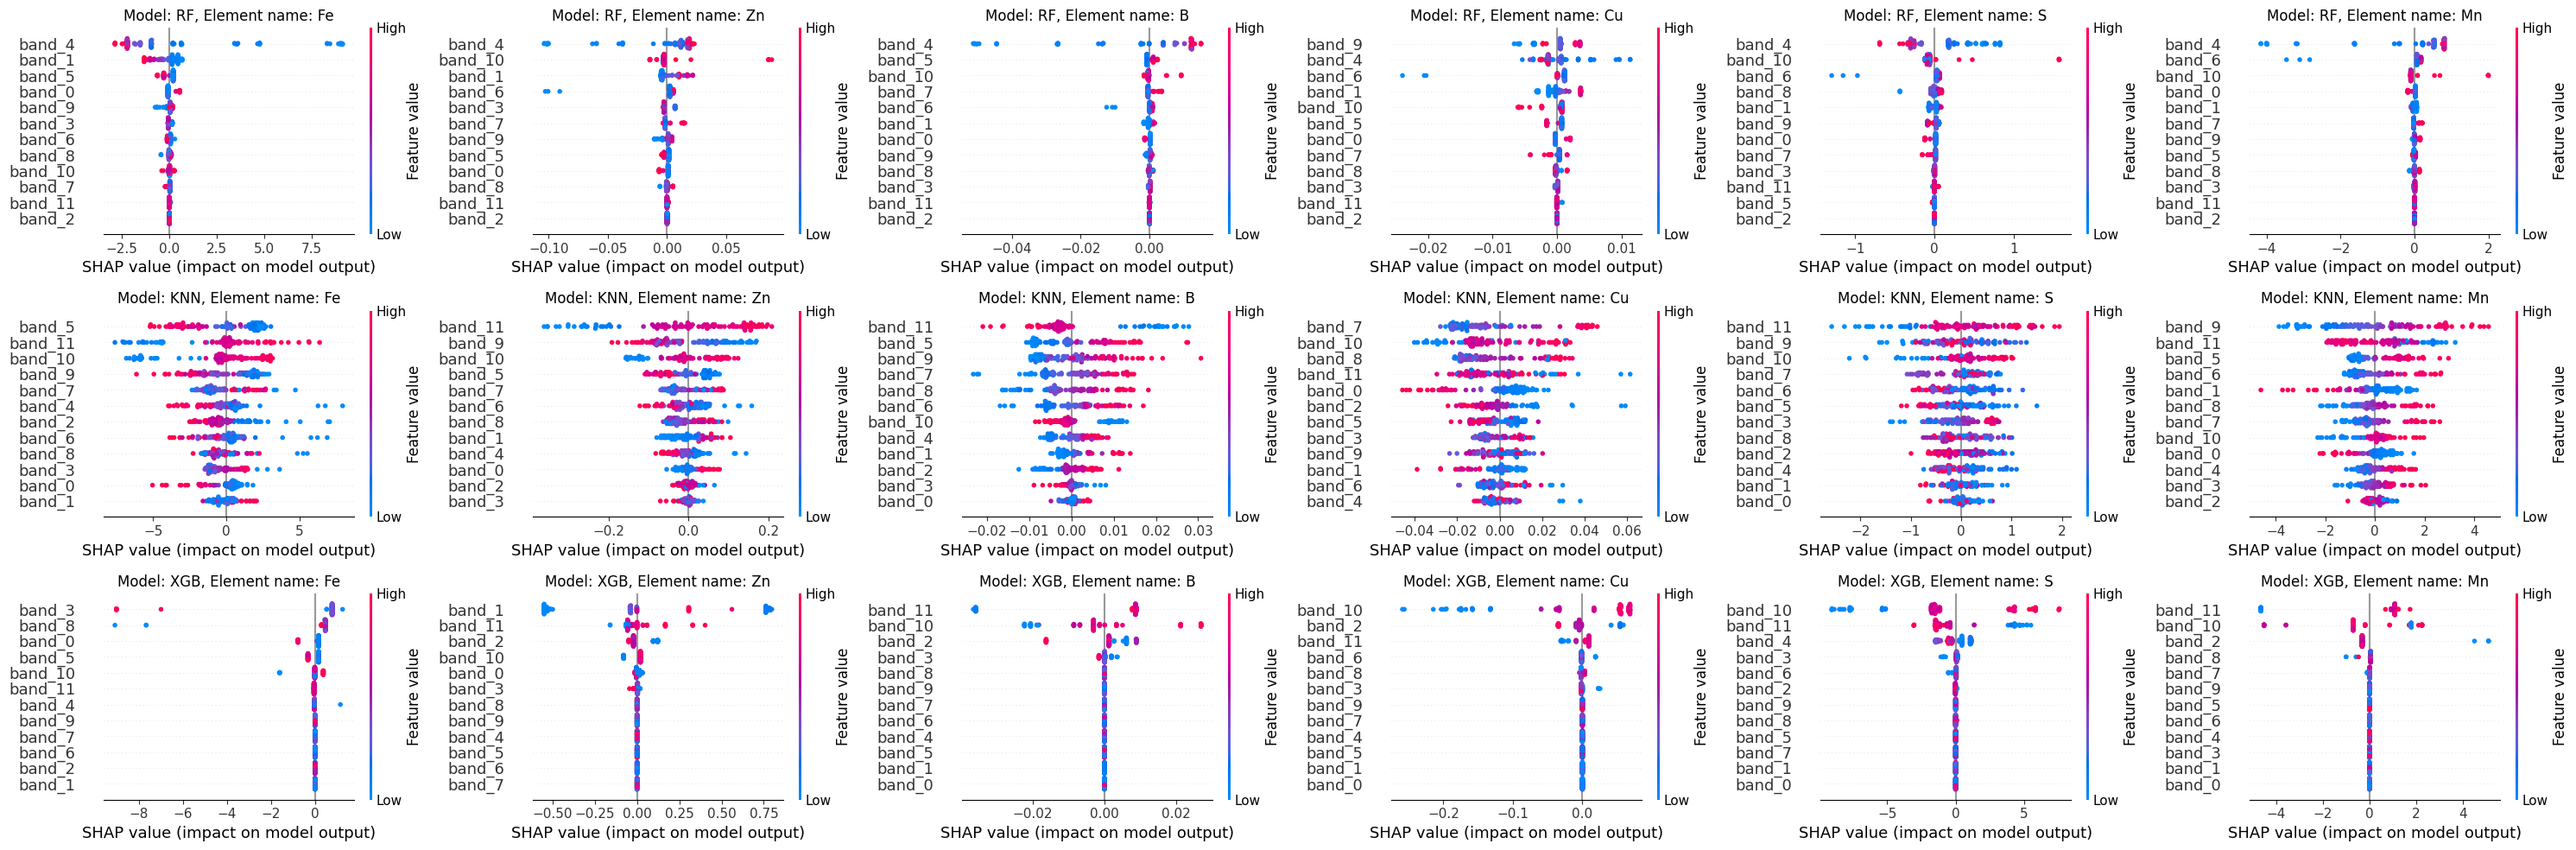

In [18]:
plt.rcParams.update({
    "figure.figsize": (30,10),
    "font.size": 12,
    "legend.fontsize": 10,
    "figure.labelsize": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
})

K, M = len(column_names), len(models)
for i in range(M):
    for j in range(K):
        ith = i * K + j
        _ = plt.subplot(M, K, ith + 1)

        model_id = i
        element_id = j
        shap.summary_plot(
            shap_model_element[model_id][element_id],
            X_eval,
            show=False, plot_size=None,
        )
        _ = plt.title(f"Model: {model_names[model_id]}, Element name: {column_names[element_id]}")

        plt.tight_layout()
plt.show()


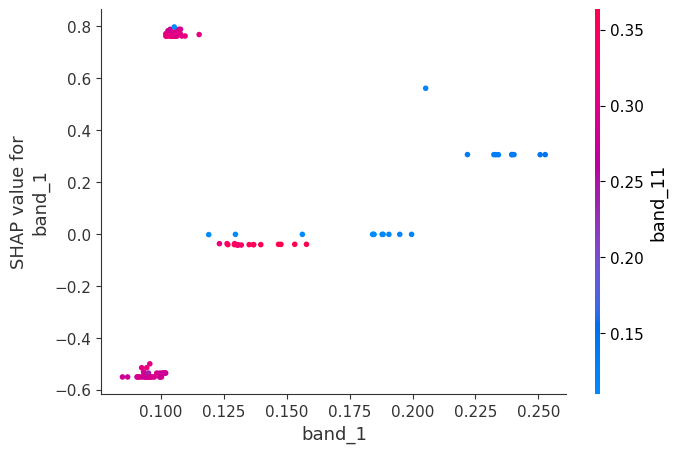

In [20]:
feature_name = "band_1"
model_id, element_id = 2,1  # model xgb, element: Zn
shap.dependence_plot(
    feature_name,
    shap_model_element[model_id][element_id],
    X_eval
)
